In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pywt

from scipy.linalg import toeplitz

from sklearn.linear_model import LinearRegression
from scipy.signal import butter, filtfilt, lfilter
from PyEMD import EMD

import timeit
from scipy import signal

In [3]:
def generate_fgn(N, H):
    gamma = lambda k, H: 0.5 * (abs(k - 1)**(2*H) - 2 * abs(k)**(2*H) + abs(k + 1)**(2*H))
    r = np.array([gamma(k, H) for k in range(N)])
    R = toeplitz(r) 
    L = np.linalg.cholesky(R) 
    fgn = np.dot(L, np.random.randn(N))
    return fgn

def generate_fgn_signal(num_points=1000, fs=100.0, H=0.75, noise_amp=0.5):
    t = np.linspace(0, num_points/fs, num_points, endpoint=False)
    
    trend = 0.12*(t**2) - 0.5*t + 2.0
    
    freq = 3.0  # Hz
    oscillation = 1.5 * np.sin(2*np.pi*freq*t)
    
    clean_signal = trend + oscillation

    fgn_noise = noise_amp * generate_fgn(num_points, H)

    x = trend + oscillation + fgn_noise
    return t, x, trend, clean_signal, fgn_noise

In [4]:
def fourier_highpass_filter(signal, fs, cutoff=0.1, order=4):
    nyquist = 0.5 * fs    
    norm_cutoff = cutoff / nyquist
    b, a = butter(order, norm_cutoff, btype='high', analog=False)
    filtered = lfilter(b, a, signal)
    return filtered

def fourier_lowpass_filter(signal, fs, cutoff=5.0, order=4):
    nyquist = 0.5 * fs
    norm_cutoff = cutoff / nyquist
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    filtered = lfilter(b, a, signal)
    return filtered

In [5]:
def wavelet_denoise(signal, wavelet='db4', level=4, threshold_mode='soft'):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    thresh = sigma * np.sqrt(2 * np.log(len(signal)))

    # Apply threshold to detail coeffs
    new_coeffs = [coeffs[0]] 
    for detail_level in coeffs[1:]:
        new_detail = pywt.threshold(detail_level, value=thresh, mode=threshold_mode)
        new_coeffs.append(new_detail)

    denoised = pywt.waverec(new_coeffs, wavelet)
    return denoised[:len(signal)]

def wavelet_detrend(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[0] = np.zeros_like(coeffs[0])
    detrended = pywt.waverec(coeffs, wavelet)
    return detrended[:len(signal)]


In [6]:
def emd_decompose(signal, max_imf=None):
    emd = EMD()
    if max_imf is not None:
        emd.max_imf = max_imf
    imfs = emd.emd(signal)
    return imfs

def emd_detrend(signal, d=1, max_imf=None):
    imfs = emd_decompose(signal, max_imf=max_imf)
    detrended = np.sum(imfs[:-d], axis=0)
    return detrended, imfs

def emd_denoise(signal, d=1, max_imf=None):
    imfs = emd_decompose(signal, max_imf=max_imf)
    denoised = np.sum(imfs[d:], axis=0)
    return denoised, imfs

In [7]:
import numpy as np

def empirical_mean_test(imfs, sensitivity=1.5):
    num_imfs = imfs.shape[0]
    std_means = []

    # Compute standardized empirical mean for each partial reconstruction
    for d in range(1, num_imfs+1):
        partial_sum = np.sum(imfs[:d, :], axis=0)
        std_means.append(np.mean(partial_sum) / np.std(partial_sum))  # Standardized mean

    std_means = np.array(std_means)

    # Compute first derivative (rate of change)
    rate_of_change = np.abs(np.diff(std_means))

    # Compute adaptive threshold based on median + sensitivity * std deviation
    threshold = np.median(rate_of_change) + sensitivity * np.std(rate_of_change)  

    # Find the first index where the rate of change exceeds the adaptive threshold
    for d in range(len(rate_of_change)):
        if rate_of_change[d] > threshold:
            return d + 1  # First index where change is significant

    return num_imfs


def detrend_signal(imfs, D):
    return np.sum(imfs[:D, :], axis=0)

In [8]:
def compute_imf_energy(imfs):
    return np.array([np.sum(imf**2) for imf in imfs])

def noise_threshold_denoising(imfs, H=0.5):
    num_imfs = imfs.shape[0]
    energies = compute_imf_energy(imfs)

    rho_H = 2  # Approximation from paper
    beta_H = 1.0  # Can be tuned
    C_H = energies[0] / beta_H

    theoretical_energy = [C_H * rho_H**(-2*(1-H)*k) for k in range(1, num_imfs+1)]
    
    # Threshold: keep only IMFs where observed energy > theoretical noise level
    denoised_imfs = [imfs[k] for k in range(num_imfs) if energies[k] > theoretical_energy[k]]

    return np.sum(denoised_imfs, axis=0)

In [9]:
def mean_absolute_trend_error(detrended_signal, true_oscillation):
    return np.mean(np.abs(detrended_signal - true_oscillation))

def spectral_analysis(original_signal, processed_signal, fs, title="PSD Comparison"):
    f_orig, Pxx_orig = signal.welch(original_signal, fs, nperseg=256)
    f_proc, Pxx_proc = signal.welch(processed_signal, fs, nperseg=256)

    plt.figure(figsize=(10, 5))
    plt.semilogy(f_orig, Pxx_orig, label="Original")
    plt.semilogy(f_proc, Pxx_proc, label="Processed", linestyle="--")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD")
    plt.legend()
    plt.title(title)
    plt.grid()
    plt.show()


def snr(original_clean, denoised_signal):
    noise = denoised_signal - original_clean
    snr_value = 10 * np.log10(np.sum(original_clean**2) / np.sum(noise**2))
    return snr_value

def peak_snr(original_clean, denoised_signal):
    mse = np.mean((original_clean - denoised_signal) ** 2)
    max_val = np.max(original_clean)
    psnr_value = 10 * np.log10(max_val**2 / mse)
    return psnr_value

def benchmark_method(method, *args, **kwargs):
    start_time = timeit.default_timer()
    result = method(*args, **kwargs)
    end_time = timeit.default_timer()
    execution_time = (end_time - start_time) * 1000.0  # in milliseconds
    return result, execution_time

In [10]:
fs = 80.0
H_true = 0.8  # Set Hurst exponent for fGn
t, x_fgn, true_trend, clean_signal, fgn_noise = generate_fgn_signal(num_points=1000, fs=fs, H=H_true, noise_amp=0.5)

In [11]:
x_fourier_gfn_detrend = fourier_highpass_filter(x_fgn, fs, cutoff=0.3)
x_fourier_gfn_denoise = fourier_lowpass_filter(x_fgn, fs, cutoff=5.0)

In [12]:
x_wavelet_gfn_detrend = wavelet_detrend(x_fgn, wavelet='db4', level=4)
x_wavelet_gfn_denoise = wavelet_denoise(x_fgn, wavelet='db4', level=4)

In [13]:
x_emd_naive_gfn_detrend, imfs_gfn_detrend = emd_detrend(x_fgn)
x_emd_naive_gfn_denoise, imfs_gfn_denoise = emd_denoise(x_fgn, d=2)

In [14]:
imfs = emd_decompose(x_fgn)
# D = empirical_mean_test(imfs, threshold=0.025)
D = empirical_mean_test(imfs, sensitivity=1.5)
x_emd_gfn_detrend = detrend_signal(imfs, D)
x_emd_gfn_denoised = noise_threshold_denoising(imfs, H=1)

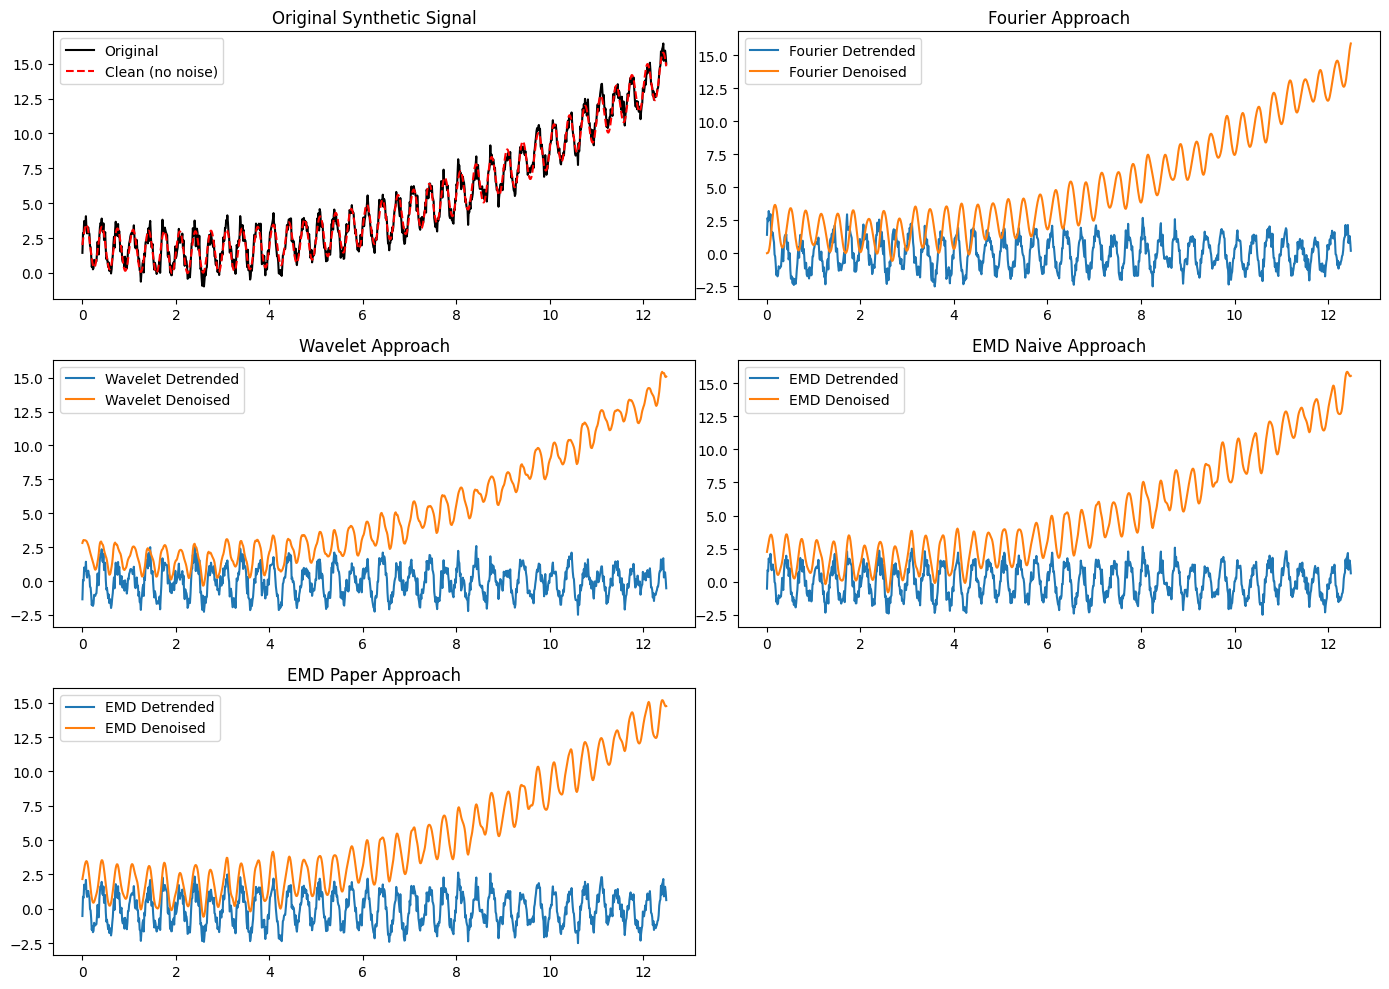

In [15]:
plt.figure(figsize=(14,10))

# Original
plt.subplot(3,2,1)
plt.plot(t, x_fgn, 'k', label='Original')
plt.plot(t, clean_signal, 'r--', label='Clean (no noise)')
plt.title('Original Synthetic Signal')
plt.legend()

# Fourier
plt.subplot(3,2,2)
plt.plot(t, x_fourier_gfn_detrend, label='Fourier Detrended')
plt.plot(t, x_fourier_gfn_denoise, label='Fourier Denoised')
plt.title('Fourier Approach')
plt.legend()

# Wavelet
plt.subplot(3,2,3)
plt.plot(t, x_wavelet_gfn_detrend, label='Wavelet Detrended')
plt.plot(t, x_wavelet_gfn_denoise, label='Wavelet Denoised')
plt.title('Wavelet Approach')
plt.legend()

# EMD
plt.subplot(3,2,4)
plt.plot(t, x_emd_naive_gfn_detrend, label='EMD Detrended')
plt.plot(t, x_emd_naive_gfn_denoise, label='EMD Denoised')
plt.title('EMD Naive Approach')
plt.legend()

# EMD (empirical mean test)
plt.subplot(3,2,5)
plt.plot(t, x_emd_gfn_detrend, label='EMD Detrended')
plt.plot(t, x_emd_gfn_denoised, label='EMD Denoised')
plt.title('EMD Paper Approach')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Compute MATE for detrending
mate_fourier = mean_absolute_trend_error(x_fourier_gfn_detrend, clean_signal)
mate_wavelet = mean_absolute_trend_error(x_wavelet_gfn_detrend, clean_signal)
mate_emd_naive = mean_absolute_trend_error(x_emd_naive_gfn_detrend, clean_signal)
mate_emd_stat = mean_absolute_trend_error(x_emd_gfn_detrend, clean_signal)

# Compute SNR for denoising
snr_fourier = snr(clean_signal, x_fourier_gfn_denoise)
snr_wavelet = snr(clean_signal, x_wavelet_gfn_denoise)
snr_emd_naive = snr(clean_signal, x_emd_naive_gfn_denoise)
snr_emd_stat = snr(clean_signal, x_emd_gfn_denoised)

# Compute PSNR for denoising
psnr_fourier = peak_snr(clean_signal, x_fourier_gfn_denoise)
psnr_wavelet = peak_snr(clean_signal, x_wavelet_gfn_denoise)
psnr_emd_naive = peak_snr(clean_signal, x_emd_naive_gfn_denoise)
psnr_emd_stat = peak_snr(clean_signal, x_emd_gfn_denoised)

# Benchmark Execution Times
_, time_fourier = benchmark_method(fourier_lowpass_filter, x_fgn, fs, 5.0)
_, time_wavelet = benchmark_method(wavelet_denoise, x_fgn, wavelet='db4', level=4)
_, time_emd_naive = benchmark_method(emd_denoise, x_fgn, d=2)
_, time_emd_stat = benchmark_method(noise_threshold_denoising, imfs, H=H_true)

# Print Results
print("\n🔹 Benchmark Results 🔹")
print(f"MATE (Detrending Error) - Fourier: {mate_fourier:.5f}, Wavelet: {mate_wavelet:.5f}, EMD-Naive: {mate_emd_naive:.5f}, EMD-Stat: {mate_emd_stat:.5f}")
print(f"SNR Improvement - Fourier: {snr_fourier:.2f} dB, Wavelet: {snr_wavelet:.2f} dB, EMD-Naive: {snr_emd_naive:.2f} dB, EMD-Stat: {snr_emd_stat:.2f} dB")
print(f"PSNR - Fourier: {psnr_fourier:.2f}, Wavelet: {psnr_wavelet:.2f}, EMD-Naive: {psnr_emd_naive:.2f}, EMD-Stat: {psnr_emd_stat:.2f}")
print(f"Execution Time (seconds) - Fourier: {time_fourier:.4f}, Wavelet: {time_wavelet:.4f}, EMD-Naive: {time_emd_naive:.4f}, EMD-Stat: {time_emd_stat:.4f}")



🔹 Benchmark Results 🔹
MATE (Detrending Error) - Fourier: 5.12347, Wavelet: 5.12707, EMD-Naive: 5.12981, EMD-Stat: 5.12981
SNR Improvement - Fourier: 12.46 dB, Wavelet: 22.41 dB, EMD-Naive: 26.21 dB, EMD-Stat: 26.47 dB
PSNR - Fourier: 20.15, Wavelet: 30.10, EMD-Naive: 33.90, EMD-Stat: 34.16
Execution Time (seconds) - Fourier: 0.3219, Wavelet: 0.3543, EMD-Naive: 17.0208, EMD-Stat: 0.0377


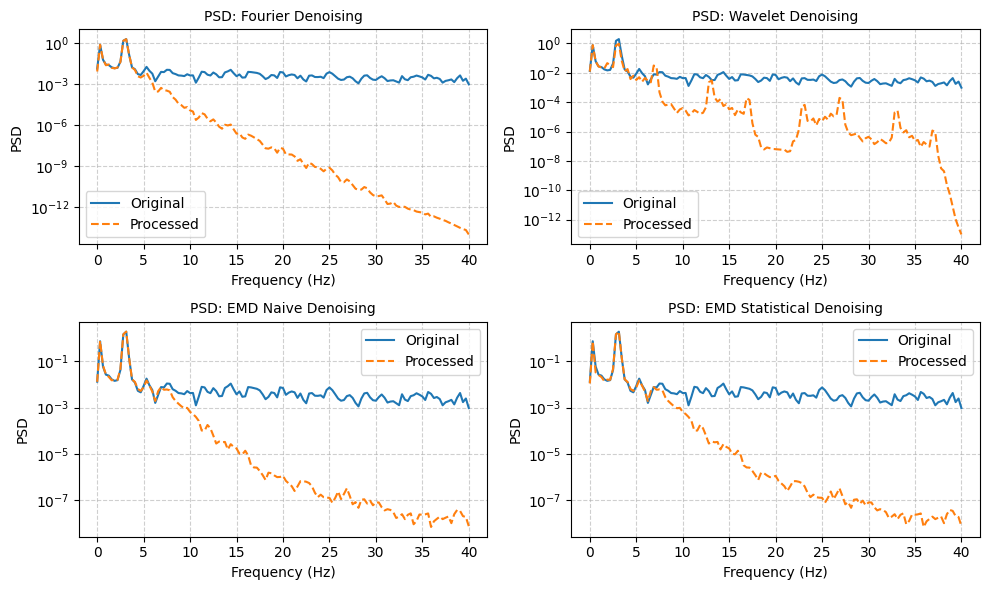

In [17]:
# Define subplot layout
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# List of signals and titles
signals = [
    (x_fgn, x_fourier_gfn_denoise, "PSD: Fourier Denoising"),
    (x_fgn, x_wavelet_gfn_denoise, "PSD: Wavelet Denoising"),
    (x_fgn, x_emd_naive_gfn_denoise, "PSD: EMD Naive Denoising"),
    (x_fgn, x_emd_gfn_denoised, "PSD: EMD Statistical Denoising")
]

# Iterate over subplots and plot PSD for each method
for ax, (orig_signal, proc_signal, title) in zip(axes.flat, signals):
    f_orig, Pxx_orig = signal.welch(orig_signal, fs, nperseg=256)
    f_proc, Pxx_proc = signal.welch(proc_signal, fs, nperseg=256)

    ax.semilogy(f_orig, Pxx_orig, label="Original", color="C0")
    ax.semilogy(f_proc, Pxx_proc, label="Processed", linestyle="--", color="C1")

    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("PSD")
    ax.set_title(title, fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
tries = 500
fs = 80.0
H_true = 0.8  # Set Hurst exponent for fGn
mate_scores = np.zeros((tries, 4))
snr_scores = np.zeros((tries, 4))
psnr_scores = np.zeros((tries, 4))
time_scores = np.zeros((tries, 4))
for i in range(tries):
    t, x_fgn, true_trend, clean_signal, fgn_noise = generate_fgn_signal(num_points=1000, fs=fs, H=H_true, noise_amp=0.5)
    x_fourier_gfn_detrend = fourier_highpass_filter(x_fgn, fs, cutoff=0.3)
    x_fourier_gfn_denoise = fourier_lowpass_filter(x_fgn, fs, cutoff=5.0)
    x_wavelet_gfn_detrend = wavelet_detrend(x_fgn, wavelet='db4', level=4)
    x_wavelet_gfn_denoise = wavelet_denoise(x_fgn, wavelet='db4', level=4)
    x_emd_naive_gfn_detrend, _ = emd_detrend(x_fgn)
    x_emd_naive_gfn_denoise, _ = emd_denoise(x_fgn, d=2)
    imfs = emd_decompose(x_fgn)
    D = empirical_mean_test(imfs, sensitivity=1.5)
    x_emd_gfn_detrend = detrend_signal(imfs, D)
    x_emd_gfn_denoised = noise_threshold_denoising(imfs, H=1)
    # Compute MATE for detrending
    mate_fourier = mean_absolute_trend_error(x_fourier_gfn_detrend, clean_signal)
    mate_wavelet = mean_absolute_trend_error(x_wavelet_gfn_detrend, clean_signal)
    mate_emd_naive = mean_absolute_trend_error(x_emd_naive_gfn_detrend, clean_signal)
    mate_emd_stat = mean_absolute_trend_error(x_emd_gfn_detrend, clean_signal)
    # Compute SNR for denoising
    snr_fourier = snr(clean_signal, x_fourier_gfn_denoise)
    snr_wavelet = snr(clean_signal, x_wavelet_gfn_denoise)
    snr_emd_naive = snr(clean_signal, x_emd_naive_gfn_denoise)
    snr_emd_stat = snr(clean_signal, x_emd_gfn_denoised)
    # Compute PSNR for denoising
    psnr_fourier = peak_snr(clean_signal, x_fourier_gfn_denoise)
    psnr_wavelet = peak_snr(clean_signal, x_wavelet_gfn_denoise)
    psnr_emd_naive = peak_snr(clean_signal, x_emd_naive_gfn_denoise)
    psnr_emd_stat = peak_snr(clean_signal, x_emd_gfn_denoised)
    # Benchmark Execution Times
    _, time_fourier = benchmark_method(fourier_lowpass_filter, x_fgn, fs, 5.0)
    _, time_wavelet = benchmark_method(wavelet_denoise, x_fgn, wavelet='db4', level=4)
    _, time_emd_naive = benchmark_method(emd_denoise, x_fgn, d=2)
    _, time_emd_stat = benchmark_method(noise_threshold_denoising, imfs, H=H_true)
    # Store Results
    mate_scores[i] = [mate_fourier, mate_wavelet, mate_emd_naive, mate_emd_stat]
    snr_scores[i] = [snr_fourier, snr_wavelet, snr_emd_naive, snr_emd_stat]
    psnr_scores[i] = [psnr_fourier, psnr_wavelet, psnr_emd_naive, psnr_emd_stat]
    time_scores[i] = [time_fourier, time_wavelet, time_emd_naive, time_emd_stat]
    

In [ ]:
# Compute Mean Scores
mean_mate_scores = np.mean(mate_scores, axis=0)
mean_snr_scores = np.mean(snr_scores, axis=0)
mean_psnr_scores = np.mean(psnr_scores, axis=0)
mean_time_scores = np.mean(time_scores, axis=0)

# Compute Standard Deviation
std_mate_scores = np.std(mate_scores, axis=0)
std_snr_scores = np.std(snr_scores, axis=0)
std_psnr_scores = np.std(psnr_scores, axis=0)
std_time_scores = np.std(time_scores, axis=0)

# Print Results
print("\n🔹 Average Benchmark Results 🔹")
print(f"MATE (Detrending Error) - Fourier: {mean_mate_scores[0]:.5f} ± {std_mate_scores[0]:.5f}, Wavelet: {mean_mate_scores[1]:.5f} ± {std_mate_scores[1]:.5f}, EMD-Naive: {mean_mate_scores[2]:.5f} ± {std_mate_scores[2]:.5f}, EMD-Stat: {mean_mate_scores[3]:.5f} ± {std_mate_scores[3]:.5f}")
print(f"SNR Improvement - Fourier: {mean_snr_scores[0]:.2f} ± {std_snr_scores[0]:.2f} dB, Wavelet: {mean_snr_scores[1]:.2f} ± {std_snr_scores[1]:.2f} dB, EMD-Naive: {mean_snr_scores[2]:.2f} ± {std_snr_scores[2]:.2f} dB, EMD-Stat: {mean_snr_scores[3]:.2f} ± {std_snr_scores[3]:.2f} dB")
print(f"PSNR - Fourier: {mean_psnr_scores[0]:.2f} ± {std_psnr_scores[0]:.2f}, Wavelet: {mean_psnr_scores[1]:.2f} ± {std_psnr_scores[1]:.2f}, EMD-Naive: {mean_psnr_scores[2]:.2f} ± {std_psnr_scores[2]:.2f}, EMD-Stat: {mean_psnr_scores[3]:.2f} ± {std_psnr_scores[3]:.2f}")
print(f"Execution Time (seconds) - Fourier: {mean_time_scores[0]:.4f} ± {std_time_scores[0]:.4f}, Wavelet: {mean_time_scores[1]:.4f} ± {std_time_scores[1]:.4f}, EMD-Naive: {mean_time_scores[2]:.4f} ± {std_time_scores[2]:.4f}, EMD-Stat: {mean_time_scores[3]:.4f} ± {std_time_scores[3]:.4f}")


In [ ]:
# Plot Results
plt.figure(figsize=(12, 6))
labels = ['Fourier', 'Wavelet', 'EMD-Naive', 'EMD-Stat']
x = np.arange(len(labels))
width = 0.2
plt.bar(x - 2*width, mean_mate_scores, width, yerr=std_mate_scores, label='MATE', color='skyblue')
plt.bar(x - width, mean_snr_scores, width, yerr=std_snr_scores, label='SNR', color='salmon')
plt.bar(x, mean_psnr_scores, width, yerr=std_psnr_scores, label='PSNR', color='lightgreen')
plt.bar(x + width, mean_time_scores, width, yerr=std_time_scores, label='Execution Time', color='gold')
plt.xticks(x, labels)
plt.ylabel('Scores')
plt.title('Average Benchmark Results')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Convert time scores to milliseconds


# Compute statistics for EMD-Stat MATE
mate_emd_stat_values = mate_scores[:, 3]  # Extract only EMD-Stat MATE values
mean_mate_emd_stat = np.mean(mate_emd_stat_values)
std_mate_emd_stat = np.std(mate_emd_stat_values)

z_scores = np.abs((mate_emd_stat_values - mean_mate_emd_stat) / std_mate_emd_stat)
valid_indices = np.where(z_scores < 2)[0]  # Only keep values within 2 std devs

# Filter results using valid indices
mate_scores_filtered = mate_scores[valid_indices]
snr_scores_filtered = snr_scores[valid_indices]
psnr_scores_filtered = psnr_scores[valid_indices]
time_scores_filtered = time_scores[valid_indices]

# Compute new means and standard deviations
mate_means = np.mean(mate_scores_filtered, axis=0)
mate_stds = np.std(mate_scores_filtered, axis=0)

snr_means = np.mean(snr_scores_filtered, axis=0)
snr_stds = np.std(snr_scores_filtered, axis=0)

psnr_means = np.mean(psnr_scores_filtered, axis=0)
psnr_stds = np.std(psnr_scores_filtered, axis=0)

time_means = np.mean(time_scores_filtered, axis=0)
time_stds = np.std(time_scores_filtered, axis=0)

# Define method names for plotting
methods = ["Fourier", "Wavelet", "EMD-Naïve", "EMD-Stat"]

# Print Filtered Results
print("\n🔹 **Filtered Benchmark Results (Excluding Bad EMD-Stat Runs)** 🔹")
for i, method in enumerate(methods):
    print(f"\n🛠 **{method}**:")
    print(f"📉 MATE: {mate_means[i]:.5f} ± {mate_stds[i]:.5f}")
    print(f"📈 SNR: {snr_means[i]:.2f} ± {snr_stds[i]:.2f} dB")
    print(f"🔊 PSNR: {psnr_means[i]:.2f} ± {psnr_stds[i]:.2f}")
    print(f"⏱ Execution Time: {time_means[i]:.2f} ± {time_stds[i]:.2f} ms")


In [ ]:
# Plot Results
plt.figure(figsize=(12, 6))
labels = ['Fourier', 'Wavelet', 'EMD-Naive', 'EMD-Stat']
x = np.arange(len(labels))
width = 0.2
plt.bar(x - 2*width, mate_means, width, yerr=mate_stds, label='MATE', color='skyblue')
plt.bar(x - width, snr_means, width, yerr=snr_stds, label='SNR', color='salmon')
plt.bar(x, psnr_means, width, yerr=psnr_stds, label='PSNR', color='lightgreen')
plt.bar(x + width, time_means, width, yerr=time_stds, label='Execution Time', color='gold')
plt.xticks(x, labels)
plt.ylabel('Scores')
plt.title('Average Benchmark Results')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Fourier', 'Wavelet', 'EMD-Naive', 'EMD-Stat']
x = np.arange(len(labels))  # x positions for bars
width = 0.2  # Width of each bar

fig, ax = plt.subplots(2, 1, figsize=(6, 6))  # Create two subplots

# First plot
ax[0].bar(x - 2*width, mean_mate_scores, width, yerr=std_mate_scores, label='MATE', color='skyblue', capsize=5)
ax[0].bar(x - width, mean_snr_scores, width, yerr=std_snr_scores, label='SNR', color='salmon', capsize=5)
ax[0].bar(x, mean_psnr_scores, width, yerr=std_psnr_scores, label='PSNR', color='lightgreen', capsize=5)
ax[0].bar(x + width, mean_time_scores, width, yerr=std_time_scores, label='Execution Time', color='gold', capsize=5)

ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].set_ylabel('Scores')
ax[0].set_title('Average Benchmark Results')
ax[0].legend()
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# Second plot (if using different datasets)
ax[1].bar(x - 2*width, mate_means, width, yerr=mate_stds, label='MATE', color='skyblue', capsize=5)
ax[1].bar(x - width, snr_means, width, yerr=snr_stds, label='SNR', color='salmon', capsize=5)
ax[1].bar(x, psnr_means, width, yerr=psnr_stds, label='PSNR', color='lightgreen', capsize=5)
ax[1].bar(x + width, time_means, width, yerr=time_stds, label='Execution Time', color='gold', capsize=5)

ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].set_ylabel('Scores')
ax[1].set_title('Alternative Benchmark Results')
ax[1].legend()
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load NASA temperature data
url = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"
df = pd.read_csv(url, skiprows=1)  # Skip metadata rows

df["Annual_Mean"] = df.iloc[:, 1:13].mean(axis=1)  # Compute annual mean temperature

t_nasa = df["Year"].values
x_nasa = df["Annual_Mean"].values


In [ ]:
import yfinance as yf

# Download historical stock data
ticker = "NVDA"  # Example: Apple stock
data = yf.download(ticker, start="2024-01-01", end="2024-12-31", interval="1d")

# Extract Closing Prices
t_stock = data.index
x_stock = data["Close"].values
x_stock = x_stock.squeeze()

In [ ]:
import matplotlib.pyplot as plt
# Define figure size for a 2-column LaTeX paper
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=False, dpi=300)  # 3 stacked plots

# Plot each dataset
axes[0].plot(t, x_fgn, label="Synthetic (fGn)", color='C0')
axes[1].plot(t_nasa, x_nasa, label="NASA Temperature", color='C1')
axes[2].plot(t_stock, x_stock, label="Stock Market (NVDA)", color='C2')

# Formatting
for ax in axes:
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_ylabel("Amplitude")

axes[-1].set_xlabel("Time")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

# Plot NASA Temperature Data
plt.plot(t_nasa, x_nasa, label="NASA Temperature Data", color='C1')

# Formatting
plt.title("NASA Global Land-Ocean Temperature Index")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("nasa_temperature_data.png", dpi=300)

In [ ]:
plt.figure(figsize=(8, 6))

# Plot Stock Market Data
plt.plot(t_stock, x_stock, label="Stock Market Data (NVDA)", color='C2')

# Formatting
plt.title("Stock Market Data (NVDA)")
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("stock_market_data.png", dpi=300)

In [ ]:
plt.figure(figsize=(8, 6))

# Plot Synthetic fGn Signal
plt.plot(t, x_fgn, label="Synthetic fGn Signal", color='C0')

# Formatting
plt.title("Synthetic Fractional Gaussian Noise (fGn) Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("synthetic_fgn_signal.png", dpi=300)

In [ ]:
imfs_nasa = emd_decompose(x_nasa)
# Plot IMFs with different colors
plt.figure(figsize=(6, 3))
for i in range(imfs_nasa.shape[0]):
    plt.plot(t_nasa, imfs_nasa[i], label=f"IMF-{i+1}")
    
plt.title("NASA Temperature Data - EMD Decomposition")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("NASA Temperature Data - EMD Decomposition")
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")
ax.grid(True, linestyle='--', alpha=0.5)

ax.set_xlim(t_nasa.min(), t_nasa.max())
ax.set_ylim(imfs_nasa.min() - 1, imfs_nasa.max() + 1)

lines = [ax.plot([], [], label=f"IMF-{i+1}")[0] for i in range(imfs_nasa.shape[0])]

# Add legend outside the plot
ax.legend(loc='upper right')

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def update(frame):
    if frame < len(lines):
        lines[frame].set_data(t_nasa, imfs_nasa[frame])
    return lines

ani = animation.FuncAnimation(fig, update, frames=imfs_nasa.shape[0], init_func=init, blit=True, interval=800)

# Display the animation
plt.show()

ani.save('nasa_emd_decomposition.gif', writer='pillow', fps=1)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

imfs_nasa = emd_decompose(x_nasa)

fig, ax = plt.subplots(figsize=(6, 3))
ax.set_title("NASA Temperature Data - EMD Decomposition")
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")
ax.grid(True, linestyle='--', alpha=0.5)

lines = [ax.plot([], [], label=f"IMF-{i+1}")[0] for i in range(imfs_nasa.shape[0])]
ax.legend()

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def update(frame):
    for i in range(frame + 1):
        lines[i].set_data(t_nasa, imfs_nasa[i])
    return lines

ani = animation.FuncAnimation(fig, update, frames=imfs_nasa.shape[0], init_func=init, blit=True, interval=800)



In [ ]:
imfs_stock = emd_decompose(x_stock)
# Plot IMFs with different colors
plt.figure(figsize=(6, 3))
for i in range(imfs_stock.shape[0]):
    plt.plot(t_stock, imfs_stock[i], label=f"IMF-{i+1}")
    
plt.title("Stock Market Data (NVDA) - EMD Decomposition")
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
x_fourier_nasa_detrend = fourier_highpass_filter(x_nasa, fs, cutoff=1.0)
x_fourier_nasa_denoise = fourier_lowpass_filter(x_nasa, fs, cutoff=5.0)


In [ ]:
x_wavelet_nasa_detrend = wavelet_detrend(x_nasa, wavelet='db4', level=4)
x_wavelet_nasa_denoise = wavelet_denoise(x_nasa, wavelet='db4', level=4)


In [ ]:
x_emd_naive_nasa_detrend, _ = emd_detrend(x_nasa, d=3)
x_emd_naive_nasa_denoise, _ = emd_denoise(x_nasa, d=2)

In [ ]:
imfs_nasa = emd_decompose(x_nasa)
D_nasa = empirical_mean_test(imfs_nasa, sensitivity=0.1)
x_emd_nasa_detrend = detrend_signal(imfs_nasa, D_nasa)
x_emd_nasa_denoised = noise_threshold_denoising(imfs_nasa, H=1)

In [ ]:
x_fourier_stock_detrend = fourier_highpass_filter(x_stock, fs, cutoff=1.0)
x_fourier_stock_denoise = fourier_lowpass_filter(x_stock, fs, cutoff=5.0)

x_wavelet_stock_detrend = wavelet_detrend(x_stock, wavelet='db4', level=4)
x_wavelet_stock_denoise = wavelet_denoise(x_stock, wavelet='db4', level=4)

x_emd_naive_stock_detrend, _ = emd_detrend(x_stock, d=3)
x_emd_naive_stock_denoise, _ = emd_denoise(x_stock, d=4)

imfs_stock = emd_decompose(x_stock)
D_stock = empirical_mean_test(imfs_stock, sensitivity=0.01)
x_emd_stock_detrend = detrend_signal(imfs_stock, D_stock)
x_emd_stock_denoised = noise_threshold_denoising(imfs_stock, H=1.5)


In [ ]:
import matplotlib.pyplot as plt

def plot_results(t, x_original, x_fourier_detrend, x_fourier_denoise,
                 x_wavelet_detrend, x_wavelet_denoise, 
                 x_emd_naive_detrend, x_emd_naive_denoise,
                 x_emd_stat_detrend, x_emd_stat_denoise, title="Dataset"):
    
    fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)

    # Fourier Approach
    axes[0, 0].plot(t, x_original, 'k', alpha=0.7, label="Original")
    axes[0, 0].plot(t, x_fourier_detrend, label="Fourier Detrended")
    axes[0, 0].plot(t, x_fourier_denoise, linestyle="--", label="Fourier Denoised")
    axes[0, 0].set_title("Fourier Approach")
    axes[0, 0].legend()

    # Wavelet Approach
    axes[0, 1].plot(t, x_original, 'k', alpha=0.7, label="Original")
    axes[0, 1].plot(t, x_wavelet_detrend, label="Wavelet Detrended")
    axes[0, 1].plot(t, x_wavelet_denoise, linestyle="--", label="Wavelet Denoised")
    axes[0, 1].set_title("Wavelet Approach")
    axes[0, 1].legend()

    # EMD Naive
    axes[1, 0].plot(t, x_original, 'k', alpha=0.7, label="Original")
    axes[1, 0].plot(t, x_emd_naive_detrend, label="EMD-Naive Detrended")
    axes[1, 0].plot(t, x_emd_naive_denoise, linestyle="--", label="EMD-Naive Denoised")
    axes[1, 0].set_title("EMD-Naive Approach")
    axes[1, 0].legend()

    # EMD Statistical
    axes[1, 1].plot(t, x_original, 'k', alpha=0.7, label="Original")
    axes[1, 1].plot(t, x_emd_stat_detrend, label="EMD-Stat Detrended")
    axes[1, 1].plot(t, x_emd_stat_denoise, linestyle="--", label="EMD-Stat Denoised")
    axes[1, 1].set_title("EMD-Stat Approach")
    axes[1, 1].legend()

    fig.suptitle(f"{title} - Detrending & Denoising")
    plt.tight_layout()
    plt.show()


# 🌍 NASA Temperature Data
plot_results(t_nasa, x_nasa,
             x_fourier_nasa_detrend, x_fourier_nasa_denoise,
             x_wavelet_nasa_detrend, x_wavelet_nasa_denoise,
             x_emd_naive_nasa_detrend, x_emd_naive_nasa_denoise,
             x_emd_nasa_detrend, x_emd_nasa_denoised,
             title="NASA Temperature Data")

# 📈 Stock Market Data
plot_results(t_stock, x_stock,
             x_fourier_stock_detrend, x_fourier_stock_denoise,
             x_wavelet_stock_detrend, x_wavelet_stock_denoise,
             x_emd_naive_stock_detrend, x_emd_naive_stock_denoise,
             x_emd_stock_detrend, x_emd_stock_denoised,
             title="Stock Market Data")


In [ ]:
# Compute MATE for detrending
mate_fourier_nasa = mean_absolute_trend_error(x_fourier_nasa_detrend, x_nasa)
mate_wavelet_nasa = mean_absolute_trend_error(x_wavelet_nasa_detrend, x_nasa)
mate_emd_naive_nasa = mean_absolute_trend_error(x_emd_naive_nasa_detrend, x_nasa)
mate_emd_stat_nasa = mean_absolute_trend_error(x_emd_nasa_detrend, x_nasa)

mate_fourier_stock = mean_absolute_trend_error(x_fourier_stock_detrend, x_stock)
mate_wavelet_stock = mean_absolute_trend_error(x_wavelet_stock_detrend, x_stock)
mate_emd_naive_stock = mean_absolute_trend_error(x_emd_naive_stock_detrend, x_stock)
mate_emd_stat_stock = mean_absolute_trend_error(x_emd_stock_detrend, x_stock)

# Compute SNR for denoising
snr_fourier_nasa = snr(x_nasa, x_fourier_nasa_denoise)
snr_wavelet_nasa = snr(x_nasa, x_wavelet_nasa_denoise)
snr_emd_naive_nasa = snr(x_nasa, x_emd_naive_nasa_denoise)
snr_emd_stat_nasa = snr(x_nasa, x_emd_nasa_denoised)

snr_fourier_stock = snr(x_stock, x_fourier_stock_denoise)
snr_wavelet_stock = snr(x_stock, x_wavelet_stock_denoise)
snr_emd_naive_stock = snr(x_stock, x_emd_naive_stock_denoise)
snr_emd_stat_stock = snr(x_stock, x_emd_stock_denoised)

# Compute PSNR for denoising
psnr_fourier_nasa = peak_snr(x_nasa, x_fourier_nasa_denoise)
psnr_wavelet_nasa = peak_snr(x_nasa, x_wavelet_nasa_denoise)
psnr_emd_naive_nasa = peak_snr(x_nasa, x_emd_naive_nasa_denoise)
psnr_emd_stat_nasa = peak_snr(x_nasa, x_emd_nasa_denoised)

psnr_fourier_stock = peak_snr(x_stock, x_fourier_stock_denoise)
psnr_wavelet_stock = peak_snr(x_stock, x_wavelet_stock_denoise)
psnr_emd_naive_stock = peak_snr(x_stock, x_emd_naive_stock_denoise)
psnr_emd_stat_stock = peak_snr(x_stock, x_emd_stock_denoised)

# Benchmark Execution Times
_, time_fourier_nasa = benchmark_method(fourier_lowpass_filter, x_nasa, fs, 5.0)
_, time_wavelet_nasa = benchmark_method(wavelet_denoise, x_nasa, wavelet='db4', level=4)
_, time_emd_naive_nasa = benchmark_method(emd_denoise, x_nasa, d=2)
_, time_emd_stat_nasa = benchmark_method(noise_threshold_denoising, imfs_nasa, H=1)

_, time_fourier_stock = benchmark_method(fourier_lowpass_filter, x_stock, fs, 5.0)
_, time_wavelet_stock = benchmark_method(wavelet_denoise, x_stock, wavelet='db4', level=4)
_, time_emd_naive_stock = benchmark_method(emd_denoise, x_stock, d=2)
_, time_emd_stat_stock = benchmark_method(noise_threshold_denoising, imfs_stock, H=1.5)

# Print Results
print("\n🔹 Benchmark Results (Synthetic Data) 🔹")
print(f"MATE (Detrending Error) - Fourier: {mate_fourier:.5f}, Wavelet: {mate_wavelet:.5f}, EMD-Naive: {mate_emd_naive:.5f}, EMD-Stat: {mate_emd_stat:.5f}")
print(f"SNR Improvement - Fourier: {snr_fourier:.2f} dB, Wavelet: {snr_wavelet:.2f} dB, EMD-Naive: {snr_emd_naive:.2f} dB, EMD-Stat: {snr_emd_stat:.2f} dB")
print(f"PSNR - Fourier: {psnr_fourier:.2f}, Wavelet: {psnr_wavelet:.2f}, EMD-Naive: {psnr_emd_naive:.2f}, EMD-Stat: {psnr_emd_stat:.2f}")
print(f"Execution Time (seconds) - Fourier: {time_fourier:.4f}, Wavelet: {time_wavelet:.4f}, EMD-Naive: {time_emd_naive:.4f}, EMD-Stat: {time_emd_stat:.4f}")

print("\n🔹 Benchmark Results (NASA Temperature Data) 🔹")
print(f"MATE (Detrending Error) - Fourier: {mate_fourier_nasa:.5f}, Wavelet: {mate_wavelet_nasa:.5f}, EMD-Naive: {mate_emd_naive_nasa:.5f}, EMD-Stat: {mate_emd_stat_nasa:.5f}")
print(f"SNR Improvement - Fourier: {snr_fourier_nasa:.2f} dB, Wavelet: {snr_wavelet_nasa:.2f} dB, EMD-Naive: {snr_emd_naive_nasa:.2f} dB, EMD-Stat: {snr_emd_stat_nasa:.2f} dB")
print(f"PSNR - Fourier: {psnr_fourier_nasa:.2f}, Wavelet: {psnr_wavelet_nasa:.2f}, EMD-Naive: {psnr_emd_naive_nasa:.2f}, EMD-Stat: {psnr_emd_stat_nasa:.2f}")
print(f"Execution Time (seconds) - Fourier: {time_fourier_nasa:.4f}, Wavelet: {time_wavelet_nasa:.4f}, EMD-Naive: {time_emd_naive_nasa:.4f}, EMD-Stat: {time_emd_stat_nasa:.4f}")

print("\n🔹 Benchmark Results (Stock Market Data) 🔹")
print(f"MATE (Detrending Error) - Fourier: {mate_fourier_stock:.5f}, Wavelet: {mate_wavelet_stock:.5f}, EMD-Naive: {mate_emd_naive_stock:.5f}, EMD-Stat: {mate_emd_stat_stock:.5f}")
print(f"SNR Improvement - Fourier: {snr_fourier_stock:.2f} dB, Wavelet: {snr_wavelet_stock:.2f} dB, EMD-Naive: {snr_emd_naive_stock:.2f} dB, EMD-Stat: {snr_emd_stat_stock:.2f} dB")
print(f"PSNR - Fourier: {psnr_fourier_stock:.2f}, Wavelet: {psnr_wavelet_stock:.2f}, EMD-Naive: {psnr_emd_naive_stock:.2f}, EMD-Stat: {psnr_emd_stat_stock:.2f}")
print(f"Execution Time (seconds) - Fourier: {time_fourier_stock:.4f}, Wavelet: {time_wavelet_stock:.4f}, EMD-Naive: {time_emd_naive_stock:.4f}, EMD-Stat: {time_emd_stat_stock:.4f}")
